## Step 0: Preparation

In [ ]:
# !pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision matplotlib

In [ ]:
import os
os.environ["RAY_DEDUP_LOGS"] = "0"

In [ ]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
# from flwr_datasets import FederatedDataset

DEVICE = torch.device("cpu")
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.13.1 / PyTorch 2.5.1+cu121


#### Load dataset and preprocessing

In [ ]:
# Khi chạy bằng colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# train_1 = "E:/IAD/Intern/16_CMAPSS_using_Transformer/data/train_FD001.txt"
train_1 = "/content/drive/MyDrive/Colab Notebooks/RUL_prediction_using_Transformer/train_FD001.txt"
index_names = ['ID Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names = ['Sensor {}'.format(i) for i in range(1, 22)]
column_names = index_names + setting_names + sensor_names

train_1 = pd.read_csv(train_1, sep=' ', header=None)
train_1.drop([26, 27], axis=1, inplace=True)
train_1.columns = column_names

train_1['Remaining RUL'] = ''

In [ ]:
# remaining_rul = max_rul - cycle
max_cycle = train_1.groupby('ID Engine').count()
for idx in range(len(train_1)):
    train_1.loc[idx, 'Remaining RUL'] = max_cycle.loc[train_1.loc[idx, 'ID Engine'], 'Cycle']
train_1['Remaining RUL'] = train_1['Remaining RUL'] - train_1['Cycle']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train_1 = train_1.drop(['Setting 1','Setting 2', 'Sensor 1', 'Setting 3','Sensor 5','Sensor 6', 'Sensor 10', 'Sensor 16', 'Sensor 18','Sensor 19'], axis=1)
train_1.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID Engine,Cycle,Sensor 2,Sensor 3,Sensor 4,Sensor 7,Sensor 8,Sensor 9,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 17,Sensor 20,Sensor 21,Remaining RUL
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


In [ ]:
# Normalization
df = train_1.copy()
scaled_columns = df.columns[2:]
scaler = MinMaxScaler()
df[scaled_columns] = scaler.fit_transform(df[scaled_columns])
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,ID Engine,Cycle,Sensor 2,Sensor 3,Sensor 4,Sensor 7,Sensor 8,Sensor 9,Sensor 11,Sensor 12,Sensor 13,Sensor 14,Sensor 15,Sensor 17,Sensor 20,Sensor 21,Remaining RUL
0,1,1,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,0.529086
1,1,2,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,0.526316
2,1,3,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,0.523546
3,1,4,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,0.520776
4,1,5,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,0.518006


In [ ]:
def split_dataset(dataset, num_clients):
    """
    Chia dataset thành num_clients tập con đều nhau.
    Args:
        dataset: Dataset cần chia (torch.utils.data.Dataset).
        num_clients: Số lượng tập con muốn tạo.
    Returns:
        List chứa các tập con của dataset.
    """
    # Kích thước mỗi tập con
    subset_size = len(dataset) // num_clients
    sizes = [subset_size] * num_clients

    # Chia phần dư (nếu tổng dataset không chia hết)
    sizes[-1] += len(dataset) - sum(sizes)

    # Tạo danh sách các tập con
    subsets = random_split(dataset, sizes)
    return subsets

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class FD001DatasetLoader(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length
        self.sequences = []
        self.targets = []

        grouped = data.groupby('ID Engine')
        for _, group in grouped:
            values = group.drop(['ID Engine', 'Cycle', 'Remaining RUL'], axis=1).values
            rul_values = group['Remaining RUL'].values

            for i in range(len(values) - sequence_length + 1):
                self.sequences.append(values[i:i + sequence_length])
                self.targets.append(rul_values[i + sequence_length - 1])

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.float32),
            torch.tensor(self.targets[idx], dtype=torch.float32),
        )


In [ ]:
dataset = FD001DatasetLoader(df)
train_data, validation_data = train_test_split(dataset, test_size=0.2, random_state=42)

num_clients = 10
subsets_train = split_dataset(train_data, num_clients)
subsets_validation = split_dataset(validation_data, num_clients)
# Tạo DataLoader cho mỗi tập
client_loader_trains = [DataLoader(subset, batch_size=32, shuffle=True) for subset in subsets_train]
client_loader_validations = [DataLoader(subset, batch_size=32, shuffle=True) for subset in subsets_validation]

# train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)
# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


In [ ]:
for i, loader in enumerate(client_loader_trains):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")
    # start_client(train_loader=loader, test_loader=test_loader)

Client 1 will use a subset with 1418 samples
Client 2 will use a subset with 1418 samples
Client 3 will use a subset with 1418 samples
Client 4 will use a subset with 1418 samples
Client 5 will use a subset with 1418 samples
Client 6 will use a subset with 1418 samples
Client 7 will use a subset with 1418 samples
Client 8 will use a subset with 1418 samples
Client 9 will use a subset with 1418 samples
Client 10 will use a subset with 1422 samples


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for i, loader in enumerate(client_loader_validations):
    print(f"Client {i+1} will use a subset with {len(loader.dataset)} samples")
    # start_client(train_loader=loader, test_loader=test_loader)

Client 1 will use a subset with 354 samples
Client 2 will use a subset with 354 samples
Client 3 will use a subset with 354 samples
Client 4 will use a subset with 354 samples
Client 5 will use a subset with 354 samples
Client 6 will use a subset with 354 samples
Client 7 will use a subset with 354 samples
Client 8 will use a subset with 354 samples
Client 9 will use a subset with 354 samples
Client 10 will use a subset with 361 samples


## Step 1: Centralized Training with PyTorch

#### Define the Transformer model

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
        )
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        src_emb = self.input_embedding(src) + self.positional_encoding[:, :src.size(1), :]
        src_emb = src_emb.permute(1, 0, 2)  # [seq_len, batch_size, d_model]
        transformer_out = self.transformer(src_emb, src_emb)
        output = self.fc_out(transformer_out[-1, :, :])  # Lấy giá trị cuối
        return output.squeeze(-1)

#### Define train function the model

In [ ]:
def train(model, client_loader_train, client_loader_validation: None, epochs: int, verbose=False):
    input_dim = 14
    model = model.to(DEVICE)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Training Loop
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in client_loader_train:
            seq, target = batch
            seq, target = seq.to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for batch in client_loader_validation:
                seq, target = batch
                seq, target = seq.to(DEVICE), target.to(DEVICE)
                output = model(seq)
                loss = criterion(output, target)
                val_loss += loss.item()

        print(f"Epoch {epoch + 1}: Train Loss = {train_loss / len(client_loader_train)}, Val Loss = {val_loss / len(client_loader_validation)}")

In [ ]:
def predict_on_batch(model, client_loader_validation, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()
    # Lấy một vài mẫu dữ liệu từ tập val_loader
    samples, targets = next(iter(client_loader_validation))  # Lấy một batch từ validation set
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    # Dự đoán với model
    model.eval()
    val_loss = 0
    with torch.no_grad():
        predictions = model(samples)  # [batch_size]
    val_loss = criterion(predictions, targets)

    if return_actual_rul:
        # Đưa kết quả về CPU để xử lý
        samples = samples.cpu()
        targets = targets.cpu()
        predictions = predictions.cpu()

        # Đảo chuẩn hóa dữ liệu
        rul_min = scaler.data_min_[-1]
        rul_max = scaler.data_max_[-1]

        # Đưa predictions và targets về dạng thực tế
        actual_predictions = predictions.numpy() * (rul_max - rul_min) + rul_min
        actual_targets = targets.numpy() * (rul_max - rul_min) + rul_min

        if show_fig:
            # Vẽ biểu đồ so sánh dự đoán và giá trị thực tế
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(actual_predictions)), actual_predictions, label="Predicted RUL", marker='o', linestyle='-')
            plt.plot(range(len(actual_targets)), actual_targets, label="Actual RUL", marker='x', linestyle='--')
            plt.title("Comparison of Predicted and Actual RUL")
            plt.xlabel("Sample Index")
            plt.ylabel("Remaining Useful Life (RUL)")
            plt.legend()
            plt.grid(True)
            plt.show()

        return val_loss, actual_predictions, actual_targets

    return val_loss


In [ ]:
def test(model, client_loader_validation, return_actual_rul=False, show_fig=False):
    criterion = nn.MSELoss()

    samples, targets = next(iter(client_loader_validation))
    samples, targets = samples.to(DEVICE), targets.to(DEVICE)

    # Dự đoán với model
    model.eval()
    val_loss = 0
    accuracys = 0
    with torch.no_grad():
      for batch in client_loader_validation:
        samples, targets = batch
        samples, targets = samples.to(DEVICE), targets.to(DEVICE)
        predictions = model(samples)
        val_loss += criterion(predictions, targets).item()
    return val_loss / len(client_loader_validation)


#### Train the model (Centralized Transformer model)

In [ ]:
model = TransformerModel(input_dim=14, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1)
model = model.to(DEVICE)
train(model=model, client_loader_train=client_loader_trains[0], client_loader_validation=client_loader_validations[0], epochs=5)

Epoch 1: Train Loss = 0.07664164370960659, Val Loss = 0.02200596189747254
Epoch 2: Train Loss = 0.03975809916026062, Val Loss = 0.02226012883086999
Epoch 3: Train Loss = 0.032495418708357544, Val Loss = 0.018946356528128188
Epoch 4: Train Loss = 0.027713514616092047, Val Loss = 0.016423588696246345
Epoch 5: Train Loss = 0.02586087394091818, Val Loss = 0.020142849534749985


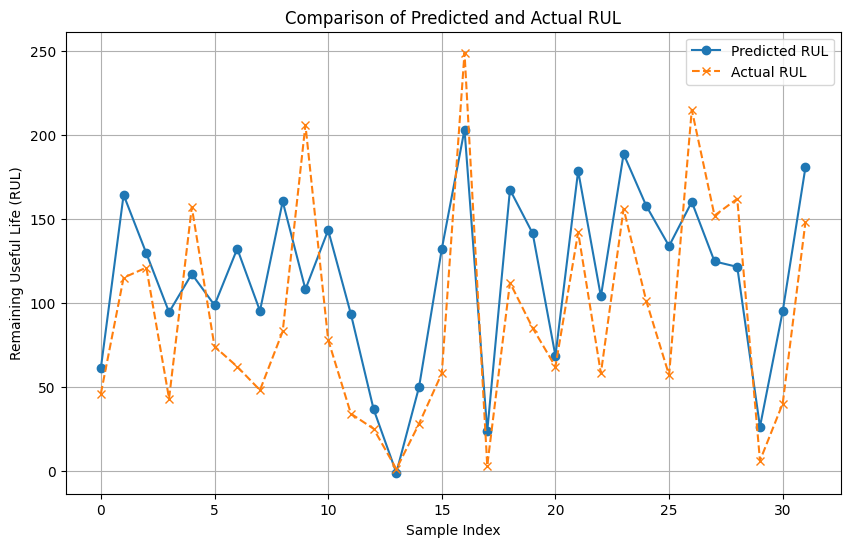

In [ ]:
# Dùng tạm validation của client 1 test thử cho model client 0 ở trên!
loss, return_actual_rul, actual_target = predict_on_batch(model=model, client_loader_validation=client_loader_validations[1], return_actual_rul=True, show_fig=True)
print(f'loss={loss}')
print(f'actual rul = {return_actual_rul}')
print(f'actual target={actual_target}')

In [ ]:
# Dùng tạm validation của client 1 test thử cho model client 0 ở trên!
loss, return_actual_rul, actual_target = predict_on_batch(model=model, client_loader_validation=client_loader_validations[2], return_actual_rul=True, show_fig=False)
print(f'loss={loss}')
print(f'actual rul = {return_actual_rul}')
print(f'actual target={actual_target}')

loss=0.018354449421167374
actual rul = [ 61.24124   164.34935   129.50685    94.42528   117.19862    98.6165
 132.25215    95.201256  160.39957   108.02502   143.30772    93.37031
  36.64953    -1.1875869  49.89301   132.05595   203.25703    23.541069
 167.42552   141.35745    68.45329   178.59053   103.79575   188.68091
 157.7042    133.8417    160.15533   124.67853   121.44043    26.141249
  94.9806    180.63242  ]
actual target=[ 46.       115.       120.99999   43.       157.        74.
  62.        48.        83.       206.        78.        34.
  25.000002   1.        28.        58.000004 249.         3.
 112.        85.        62.       142.        58.000004 156.
 101.        56.999996 215.       152.       162.         6.
  40.       148.      ]
loss=0.02156597562134266
actual rul = [104.18022   93.31729  169.99892  128.83382  173.5235   100.97742
 164.09377  187.09375   11.104717  58.2817   136.24316  166.2455
 103.27708   86.80374  131.3366   129.10936  165.32066   46.40543
 

## Step 2: Federated Learning with Flower

#### Update model parameters

In [ ]:
def set_parameters(model, parameters: List[np.ndarray]):
    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    model.load_state_dict(state_dict, strict=True)

def get_parameters(model) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

#### Define the Flower ClientApp

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, model, client_loader_train, client_loader_validation):
        self.model = model
        self.trainloader = client_loader_train
        self.valloader = client_loader_validation

    def get_parameters(self, config):
        return get_parameters(self.model)

    def fit(self, parameters, config):
        set_parameters(self.model, parameters)
        train(model=self.model, client_loader_train=self.trainloader, client_loader_validation=self.valloader, epochs=1)
        return get_parameters(self.model), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.model, parameters)
        # loss, accuracy = test(self.model, self.valloader)
        loss = test(
            model=self.model,
            client_loader_validation=self.valloader,
            return_actual_rul=False,
            show_fig=False
        )
        return float(loss), len(self.valloader), {"accuracy": float(0.0)}

In [ ]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""

    # Load model
    model = TransformerModel(input_dim=14, d_model=64, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.1).to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data partition
    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    trainloader = client_loader_trains[partition_id]
    valloader = client_loader_validations[partition_id]

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(model, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

#### Define the Flower ServerApp

In [ ]:
# Create FedAvg strategy
strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    """Construct components that set the ServerApp behaviour.

    You can use the settings in `context.run_config` to parameterize the
    construction of all elements (e.g the strategy or the number of rounds)
    wrapped in the returned ServerAppComponents object.
    """

    # Configure the server for 5 rounds of training
    config = ServerConfig(num_rounds=5)

    return ServerAppComponents(strategy=strategy, config=config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

#### Run the training

In [ ]:
# Specify the resources each of your clients need
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
# if DEVICE.type == "cuda":
#     backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}
    # Refer to our Flower framework documentation for more details about Flower simulations
    # and how to set up the `backend_config`

In [ ]:
# Run simulation
NUM_CLIENTS = 10
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=58532) 2024-11-27 14:59:03.340064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=58532) 2024-11-27 14:59:03.444439: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=58532) 2024-11-27 14:59:03.577365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=58531) 2024-11-27 14:59:04.151011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unab

(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.09795108056730695, Val Loss = 0.03170444207110753
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.10635785319738918, Val Loss = 0.02938928548246622
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.10395277854469087, Val Loss = 0.03340352140367031
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.10997434241904153, Val Loss = 0.04048606792154411
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.10574049618509081, Val Loss = 0.03525097326685985
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.11058750222954485, Val Loss = 0.02979716643070181
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.10059587731957435, Val Loss = 0.02803891741981109
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.10858549831642045, Val Loss = 0.03569062473252416


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.10783408656716346, Val Loss = 0.027129874952758353
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.10648806202742789, Val Loss = 0.02683653822168708


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.04984673195415073, Val Loss = 0.021501801442354918
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.044769924092623925, Val Loss = 0.017051366933931906
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.04894128267963727, Val Loss = 0.01458819714995722
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.04577922547856967, Val Loss = 0.015548386028967798
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.05049187950789928, Val Loss = 0.017090242123231292
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.0529716939975818, Val Loss = 0.013171990790093938
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.05017315699822373, Val Loss = 0.0153311663113224
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.053391016398866974, Val Loss = 0.015771552299459774
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.05175882445441352, Val Loss = 0.022823166490222018


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.05234931107196543, Val Loss = 0.016018732528512675


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.03657064777281549, Val Loss = 0.023842618296233315
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.03529206737875938, Val Loss = 0.015715619587960344
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.03575469797684087, Val Loss = 0.01867815355459849
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.036345464549958705, Val Loss = 0.020488942643472303
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.0362115011860927, Val Loss = 0.021657965301225584
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.03187300624946753, Val Loss = 0.013897194294258952
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.03412766754627228, Val Loss = 0.013228419702500105
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.03633979991492298, Val Loss = 0.0158623605966568
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.0367779495815436, Val Loss = 0.020577907795086503


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.03631984583205647, Val Loss = 0.01847066458625098


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.028943592278907696, Val Loss = 0.014950489237283668
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.029235802011357413, Val Loss = 0.020860686898231506
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.030072501053412755, Val Loss = 0.014113907076534815
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.03034919887367222, Val Loss = 0.011027322449384277
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.030172157742910915, Val Loss = 0.02039874290737013
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.027170518330401846, Val Loss = 0.01521228754427284
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.03118438459932804, Val Loss = 0.01226028895083194
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.027611368294391366, Val Loss = 0.012225257271590332
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.02622234279082881, Val Loss = 0.02454090164974332


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.03038713393939866, Val Loss = 0.013663850724697113


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.025667661531931823, Val Loss = 0.016204018456240494
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.026456471925808325, Val Loss = 0.015870836252967518
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.024237127312355573, Val Loss = 0.012454430339857936
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.023922017816868094, Val Loss = 0.010684230209638676
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.02375730029824707, Val Loss = 0.018868665288512904
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.026761047686967583, Val Loss = 0.015352458925917745
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.025131272172762287, Val Loss = 0.013494610320776701
(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.025160811758703657, Val Loss = 0.016975463988880318
(ClientAppActor pid=58532) Epoch 1: Train Loss = 0.023364160292678408, Val Loss = 0.013007798076917728


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)


(ClientAppActor pid=58531) Epoch 1: Train Loss = 0.02896947796559996, Val Loss = 0.01387082509851704


INFO :      aggregate_evaluate: received 5 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 5 round(s) in 879.27s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.03347433324282368
INFO :      		round 2: 0.01675256421828332
INFO :      		round 3: 0.01778992675244808
INFO :      		round 4: 0.013557928311638535
INFO :      		round 5: 0.014129420419825086
INFO :      


#### Where's the accuracy?

In [ ]:
# def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
#     # Multiply accuracy of each client by number of examples used
#     accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
#     examples = [num_examples for num_examples, _ in metrics]

#     # Aggregate and return custom metric (weighted average)
#     return {"accuracy": sum(accuracies) / sum(examples)}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# def server_fn(context: Context) -> ServerAppComponents:
#     """Construct components that set the ServerApp behaviour.

#     You can use settings in `context.run_config` to parameterize the
#     construction of all elements (e.g the strategy or the number of rounds)
#     wrapped in the returned ServerAppComponents object.
#     """

#     # Create FedAvg strategy
#     strategy = FedAvg(
#         fraction_fit=1.0,
#         fraction_evaluate=0.5,
#         min_fit_clients=10,
#         min_evaluate_clients=5,
#         min_available_clients=10,
#         evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
#     )

#     # Configure the server for 5 rounds of training
#     config = ServerConfig(num_rounds=5)

#     return ServerAppComponents(strategy=strategy, config=config)


# # Create a new server instance with the updated FedAvg strategy
# server = ServerApp(server_fn=server_fn)

# # Run simulation
# run_simulation(
#     server_app=server,
#     client_app=client,
#     num_supernodes=NUM_CLIENTS,
#     backend_config=backend_config,
# )